#  [모듈 5.4] TRANSACTION_FRAUD_INSIGHTS 로 훈련된 모델로 부터 추론 (병령로 예측)

- 5.3 노트북과 유사하지만, 추론을 병렬로 하는 부분이 다릅니다.
- 또한 추론 결과를 상세히 분석을 하여 모델 개선을 위한 토대가 됩니다.
-------


# 0. 환경 셋업

In [1]:
%store -r 

In [2]:
# -- initialize the AFD client 
import boto3
client = boto3.client('frauddetector')

import uuid
import numpy as np
from IPython.display import display as dp

# 1. 테스트 데이터 세트 준비

## 추론 샘플 사이즈

In [3]:
sample_size = 19999

## 테스트 데이터 로딩 및 샘플링


In [4]:
import pandas as pd

date_cols = ['EVENT_TIMESTAMP']
test_df = pd.read_csv(s3_test_afd_tran_data_uri, parse_dates = date_cols)
print("test_df : ", test_df.shape)
test_df = test_df.sample(n=sample_size, random_state=100)
print("Sample Size : ", test_df.shape)
test_df.head(2)

test_df :  (20000, 10)
Sample Size :  (19999, 10)


,EVENT_LABEL,ENTITY_ID,str_app,str_device,str_os,str_channel,EVENT_TIMESTAMP,ENTITY_TYPE,EVENT_ID,LABEL_TIMESTAMP
2917,0,str_93021,str_3,str_1,str_8,str_280,2020-11-09 00:08:26+00:00,customer,23729e3d-c61d-47f5-bf6f-e055150fdfb7,2020-11-09T00:08:26Z
2234,0,str_16464,str_15,str_1,str_15,str_386,2020-11-09 08:58:44+00:00,customer,6cd29b20-b615-4563-853b-066b70a7dad0,2020-11-09T08:58:44Z


## 추론 입력 포맷(Payload) 로 변경

In [5]:
record_count = test_df.shape[0]
# record_count = 500
print("record_count: ", record_count)

record_count:  19999


In [6]:
# EVENT_TIMESTAMP 리스트 준비
timestampStr_list = test_df['EVENT_TIMESTAMP'].apply(lambda x: x.strftime('%Y-%m-%dT%H:%M:%SZ'))
# ENTITY_ID 리스트 준비
entity_id_list = test_df['ENTITY_ID']
# EVENT_ID 리스트 준비
event_id_list = test_df['EVENT_ID']

# eventVariables 준비
pred_data = test_df[eventVariables].head(record_count).astype(str).to_dict(orient='records')
pred_data[0:2]

[{'str_app': 'str_3',
  'str_device': 'str_1',
  'str_os': 'str_8',
  'str_channel': 'str_280'},
 {'str_app': 'str_15',
  'str_device': 'str_1',
  'str_os': 'str_15',
  'str_channel': 'str_386'}]

# 2. 추론
- 아래는 정상적으로 실행이 될 경우에 약 2분이 소요 됩니다.
- 만약 에러가 발생하면 "병렬 처리" 에 대한 에러 입니다. 이럴 경우에 다시 한번 노트북을 실행 해 주세요.

In [7]:
%%time

import dask

@dask.delayed
def _predict(rec, event_id, entity_id, timestampStr):
    eventId = uuid.uuid1()
    try:
        pred = client.get_event_prediction(detectorId=DETECTOR_NAME, 
                                           detectorVersionId='1',
                                           eventId = event_id,
                                           eventTypeName = EVENT_TYPE,
                                           eventTimestamp = timestampStr, 
                                           entities = [{'entityType': ENTITY_TYPE, 
                                                        'entityId': entity_id
                                                       }],
                                           eventVariables=rec) 
    except:
        print("Error")

    return pred


######

predicted_dat = []

for rec , event_id, entity_id, timestampStr in zip(pred_data, event_id_list, entity_id_list, timestampStr_list):
    # print(timestampStr)
    #eventId = uuid.uuid1()
    pred = dask.delayed(_predict)(rec, event_id, entity_id, timestampStr)

    
    rec["score"]   = pred['modelScores'][0]['scores']["{0}_insightscore".format(MODEL_NAME)]
    rec["outcome"] = pred['ruleResults'][0]['outcomes'][0]
    predicted_dat.append(rec)

predict_recs = dask.compute(*predicted_dat)    

CPU times: user 1min 25s, sys: 8.46 s, total: 1min 34s
Wall time: 1min 41s


In [8]:
# -- review your predictons -- 
predictions = pd.DataFrame(predict_recs)
# predictions.head(10)
predictions

,str_app,str_device,str_os,str_channel,score,outcome
0,str_3,str_1,str_8,str_280,17.0,approve
1,str_15,str_1,str_15,str_386,21.0,approve
2,str_2,str_1,str_22,str_435,262.0,approve
3,str_9,str_1,str_19,str_466,105.0,approve
4,str_3,str_1,str_19,str_280,1.0,approve
...,...,...,...,...,...,...
19994,str_12,str_1,str_41,str_497,262.0,approve
19995,str_13,str_1,str_13,str_477,99.0,approve
19996,str_9,str_1,str_19,str_445,758.0,investigate
19997,str_6,str_1,str_22,str_125,843.0,investigate


# 3. 추론 예측 결과 값 분석


## 추론 예측 스코어 분포 확인

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


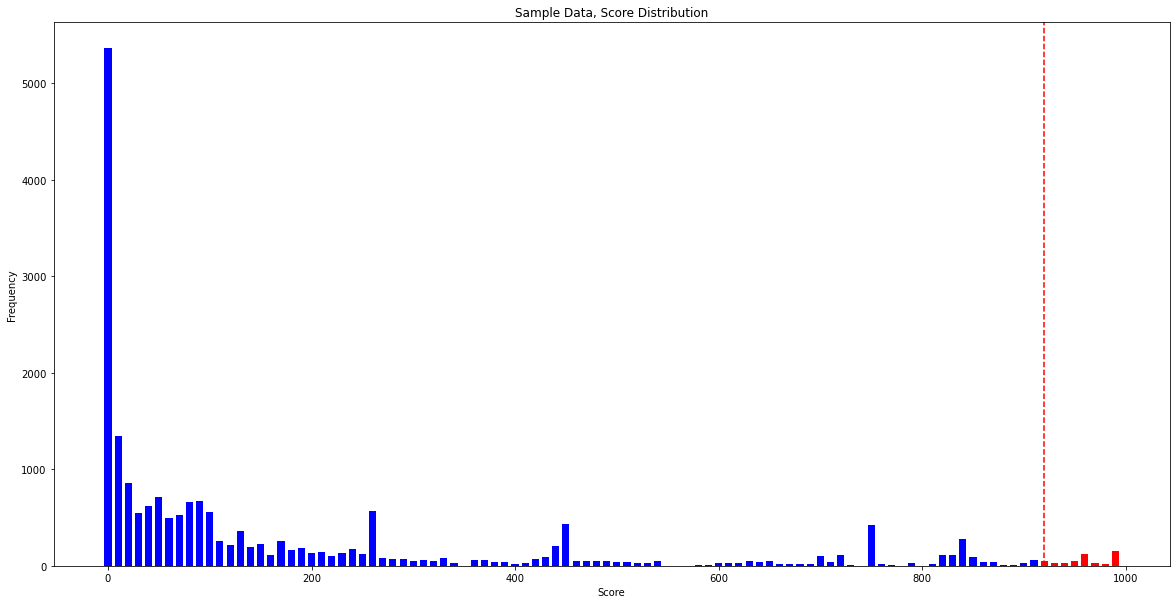

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

predictions['score_bin'] = pd.cut(predictions['score'],100 ,labels= list(range(0,1000,10)))
predictions.loc[predictions['score'] >= score_fraud_threshold, 'score_outcome'] = 'predicted_fraud'
predictions.loc[predictions['score'] < score_fraud_threshold, 'score_outcome'] = 'predicted_legit'
ctab = pd.crosstab(predictions['score_bin'], predictions['score_outcome']).reset_index()
# print(predictions.head(100))
plt.figure(figsize=(20,10))
plt.bar(ctab['score_bin'], ctab['predicted_fraud'], width=7, color='red')
plt.bar(ctab['score_bin'], ctab['predicted_legit'], width=7, color='blue')
plt.axvline(x=score_fraud_threshold, ls='--', C='red')
plt.title("Sample Data, Score Distribution")
#plt.text( 955, 700, 'score >= 985')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

## 평가 지표 생성
- F1, Precsion, Recall, Accuracy를 확인 
- Confusion Matrixa 확인

## Fraud 스코어 기준
- 아래 점수 기준으로 Fruad 로 정의 하였습니다.

In [10]:
print("score_fraud_threshold: ", score_fraud_threshold)

score_fraud_threshold:  920.0


In [11]:
#predictions['pred_label'] = np.where(predictions['outcome'] == '[approve]',0,1)
predictions['pred_label'] = np.where(predictions['outcome'] == 'fraud',1,0)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19518
           1       0.89      0.10      0.18       481

    accuracy                           0.98     19999
   macro avg       0.93      0.55      0.59     19999
weighted avg       0.98      0.98      0.97     19999

[[19512   432]
 [    6    49]]


<Figure size 432x288 with 0 Axes>

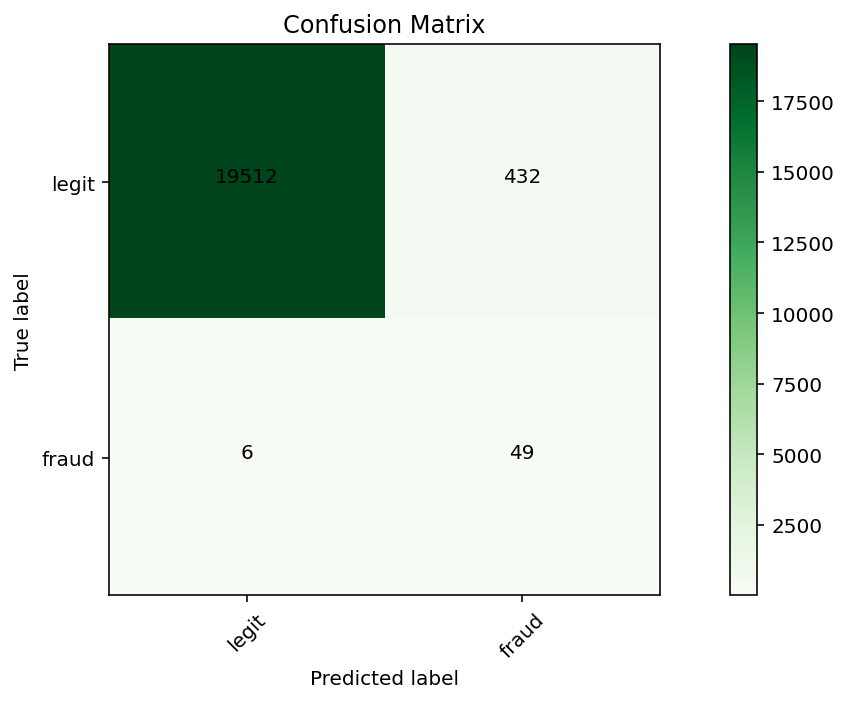

In [12]:
from sklearn.metrics import classification_report, roc_auc_score
from IPython.display import display as dp
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from src.p_utils import plot_conf_mat     

%matplotlib inline
%config InlineBackend.figure_format='retina'


def compute_f1(pred, test_df, true_label_col, pred_label_col):
    test = test_df.copy()
    test= test.reset_index(drop=True)
    print(classification_report(pred[pred_label_col], test[true_label_col]))
    
    cm = confusion_matrix(y_true= test[true_label_col], y_pred= pred[pred_label_col])
    plt.figure()
    fig, ax = plt.subplots(figsize=(10,5))
    plot_conf_mat(cm, 
                  classes=['legit', 'fraud'], 
                  title='Confusion Matrix')
    plt.show()    



compute_f1(predictions, test_df, 
           true_label_col='EVENT_LABEL',
           pred_label_col='pred_label'           
          )

# 4. 모델 타입 ONLINE_FRAUD_INSIGHTS 의 결과 비교

아래 결과는 4-2 노트북의 실행 결과 입니다. <br>
`ONLINE_FRAUD_INSIGHTS` 는 전반적으로 성능이 미세하게 안좋음

- F1-Macro
    - 0.59 --> 0.58 로 감소
- FP 
    - 432 --> 491 로 증가


```
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19459
           1       0.89      0.09      0.16       540

    accuracy                           0.98     19999
   macro avg       0.93      0.55      0.58     19999
weighted avg       0.97      0.98      0.97     19999

[[19453   491]
 [    6    49]]
```


# 5. Confusion Matrix (CM) 레코드 분석

- 실제 TP, TN, FP, FN 의 해당되는 이벤트가 어떤 것인지를 실제 레코드를 확인합니다.
- <font color="red">[중요] 이 과정은 모델이 CM 을 분류한 것을 확인하는 과정으로서, 모델 성능 개선을 위해서 반드시 수행하는 과정입니다.</font>


In [13]:
sample_df = test_df[0:record_count]

In [14]:
def create_eval_dataset(predictions, test_df):
    '''
    기존 테스트 데이터 세트에 예측 레이블, 스코어를 추가 합니다.
    '''
    eval_df = test_df.copy()
    eval_df.insert(0, column='score', value=predictions['score'].values)    
    eval_df.insert(1, column='pred_label', value=predictions['pred_label'].values)
    
    return eval_df

eval_df = create_eval_dataset(predictions, sample_df)
eval_df

,score,pred_label,EVENT_LABEL,ENTITY_ID,str_app,str_device,str_os,str_channel,EVENT_TIMESTAMP,ENTITY_TYPE,EVENT_ID,LABEL_TIMESTAMP
2917,17.0,0,0,str_93021,str_3,str_1,str_8,str_280,2020-11-09 00:08:26+00:00,customer,23729e3d-c61d-47f5-bf6f-e055150fdfb7,2020-11-09T00:08:26Z
2234,21.0,0,0,str_16464,str_15,str_1,str_15,str_386,2020-11-09 08:58:44+00:00,customer,6cd29b20-b615-4563-853b-066b70a7dad0,2020-11-09T08:58:44Z
14396,262.0,0,0,str_99519,str_2,str_1,str_22,str_435,2020-11-09 10:19:21+00:00,customer,29ba0d26-9ea2-4f04-a0bf-38256feb1f43,2020-11-09T10:19:21Z
1781,105.0,0,0,str_15643,str_9,str_1,str_19,str_466,2020-11-09 02:22:37+00:00,customer,6e0bc617-2527-434c-a325-b09792d0d846,2020-11-09T02:22:37Z
11102,1.0,0,0,str_62916,str_3,str_1,str_19,str_280,2020-11-09 05:41:45+00:00,customer,a4594013-b908-4993-af06-8b000ef0e111,2020-11-09T05:41:45Z
...,...,...,...,...,...,...,...,...,...,...,...,...
16734,262.0,0,0,str_305603,str_12,str_1,str_41,str_497,2020-11-09 06:24:16+00:00,customer,12781fee-ccb6-4565-869a-dc1d84f1db73,2020-11-09T06:24:16Z
16304,99.0,0,0,str_8505,str_13,str_1,str_13,str_477,2020-11-09 05:50:53+00:00,customer,572c3e85-e856-40c1-9cfb-9fb7e1d4e102,2020-11-09T05:50:53Z
79,758.0,0,0,str_212695,str_9,str_1,str_19,str_445,2020-11-09 11:36:44+00:00,customer,c020edc1-ac6a-4205-896c-1014f9eb4999,2020-11-09T11:36:44Z
12119,843.0,0,0,str_327491,str_6,str_1,str_22,str_125,2020-11-09 12:19:21+00:00,customer,1af7afd2-414d-457e-af17-6dde8447ca57,2020-11-09T12:19:21Z


### TP (True Positive) 분석

In [15]:
def show_classification(df, actual_col, pred_col, actual, pred):
    result = df[(df[actual_col] == actual) & (df[pred_col] == pred)]
    return result

,score,pred_label,EVENT_LABEL,ENTITY_ID,str_app,str_device,str_os,str_channel,EVENT_TIMESTAMP,ENTITY_TYPE,EVENT_ID,LABEL_TIMESTAMP
1017,965.0,1,1,str_123819,str_29,str_1,str_19,str_343,2020-11-09 08:17:21+00:00,customer,7562e9c8-b97c-4ee0-80db-d6881084eb46,2020-11-09T08:17:21Z
9069,1000.0,1,1,str_60453,str_35,str_1,str_19,str_21,2020-11-09 00:45:15+00:00,customer,211e09e8-118a-4e73-a97e-3f751f1844c5,2020-11-09T00:45:15Z
19720,956.0,1,1,str_53454,str_19,str_0,str_38,str_347,2020-11-09 07:44:29+00:00,customer,d1d218f8-62d2-449d-93fe-2aa428faaac2,2020-11-09T07:44:29Z
16637,995.0,1,1,str_341376,str_125,str_0,str_24,str_341,2020-11-09 04:32:10+00:00,customer,5b4a4993-89ea-41bd-8b50-662afe440c86,2020-11-09T04:32:10Z
2858,1000.0,1,1,str_56209,str_10,str_1,str_37,str_113,2020-11-09 01:49:08+00:00,customer,64032e71-04e2-4aec-b7ac-1ed936874253,2020-11-09T01:49:08Z


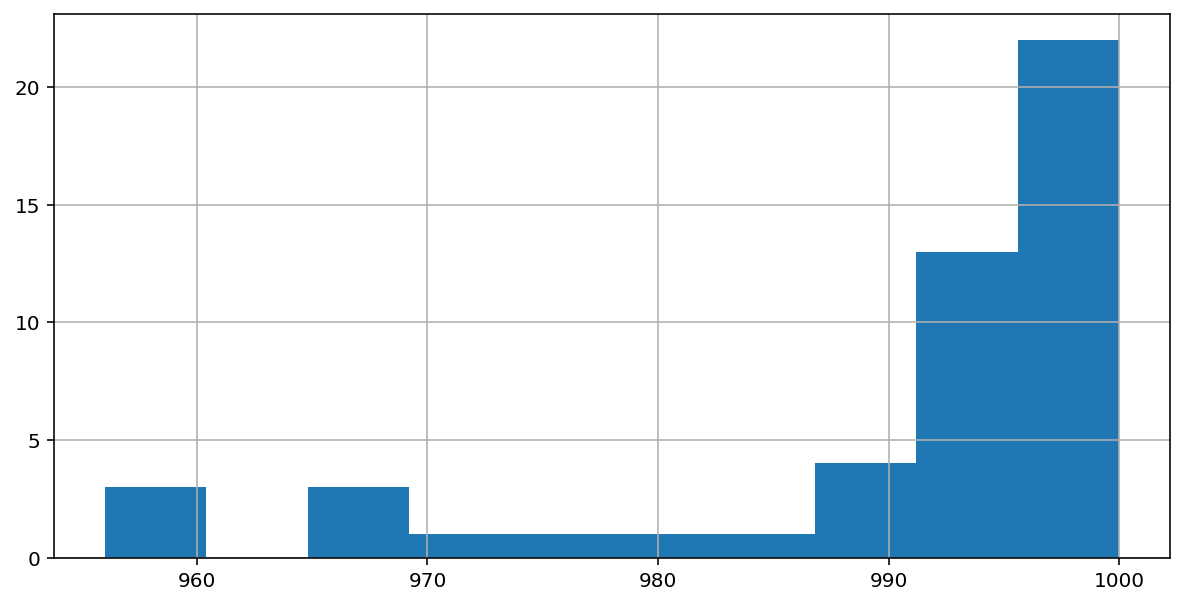

In [16]:
df_T_P =show_classification(eval_df, actual_col='EVENT_LABEL', pred_col='pred_label', actual=1, pred=1)
dp(df_T_P.head())
hist = df_T_P['score'].hist(bins=10, figsize=(10, 5))

### TN (True Negattive) 분석

,score,pred_label,EVENT_LABEL,ENTITY_ID,str_app,str_device,str_os,str_channel,EVENT_TIMESTAMP,ENTITY_TYPE,EVENT_ID,LABEL_TIMESTAMP
2917,17.0,0,0,str_93021,str_3,str_1,str_8,str_280,2020-11-09 00:08:26+00:00,customer,23729e3d-c61d-47f5-bf6f-e055150fdfb7,2020-11-09T00:08:26Z
2234,21.0,0,0,str_16464,str_15,str_1,str_15,str_386,2020-11-09 08:58:44+00:00,customer,6cd29b20-b615-4563-853b-066b70a7dad0,2020-11-09T08:58:44Z
14396,262.0,0,0,str_99519,str_2,str_1,str_22,str_435,2020-11-09 10:19:21+00:00,customer,29ba0d26-9ea2-4f04-a0bf-38256feb1f43,2020-11-09T10:19:21Z
1781,105.0,0,0,str_15643,str_9,str_1,str_19,str_466,2020-11-09 02:22:37+00:00,customer,6e0bc617-2527-434c-a325-b09792d0d846,2020-11-09T02:22:37Z
11102,1.0,0,0,str_62916,str_3,str_1,str_19,str_280,2020-11-09 05:41:45+00:00,customer,a4594013-b908-4993-af06-8b000ef0e111,2020-11-09T05:41:45Z


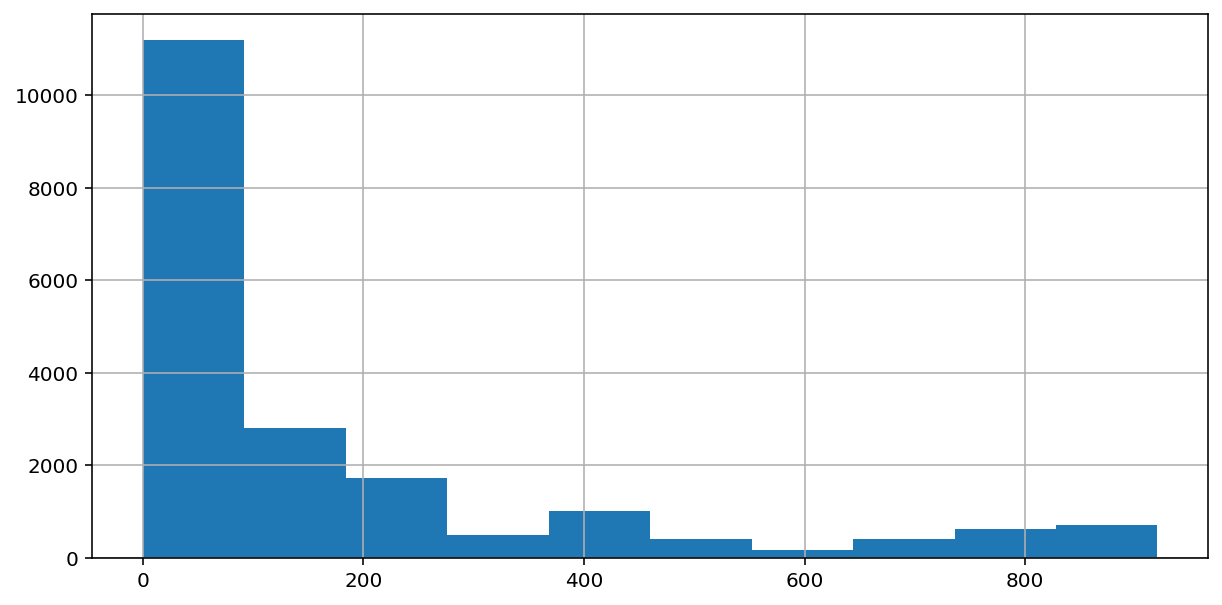

In [17]:
df_T_N =show_classification(eval_df, actual_col='EVENT_LABEL', pred_col='pred_label', actual=0, pred=0)
dp(df_T_N.head())
hist = df_T_N['score'].hist(bins=10, figsize=(10, 5))

### FN (False Negative) 분석

,score,pred_label,EVENT_LABEL,ENTITY_ID,str_app,str_device,str_os,str_channel,EVENT_TIMESTAMP,ENTITY_TYPE,EVENT_ID,LABEL_TIMESTAMP
306,118.0,0,1,str_17321,str_14,str_1,str_13,str_134,2020-11-09 08:45:37+00:00,customer,a9655028-3a4b-4dbc-b9e3-e9d943726ec1,2020-11-09T08:45:37Z
16010,858.0,0,1,str_319702,str_9,str_1,str_13,str_127,2020-11-09 13:06:46+00:00,customer,20a8a98a-5c56-4434-9170-5aa8620005a0,2020-11-09T13:06:46Z
9859,49.0,0,1,str_8499,str_11,str_1,str_13,str_137,2020-11-09 09:44:22+00:00,customer,ef9f02cd-2473-4e2f-a678-212c0fcebd51,2020-11-09T09:44:22Z
16474,868.0,0,1,str_320634,str_9,str_1,str_13,str_234,2020-11-09 02:14:55+00:00,customer,79449505-38d0-4289-82ea-729953367bd3,2020-11-09T02:14:55Z
4298,758.0,0,1,str_162113,str_18,str_1,str_19,str_121,2020-11-09 10:19:13+00:00,customer,5127e202-ca38-485e-a456-0a92066db177,2020-11-09T10:19:13Z


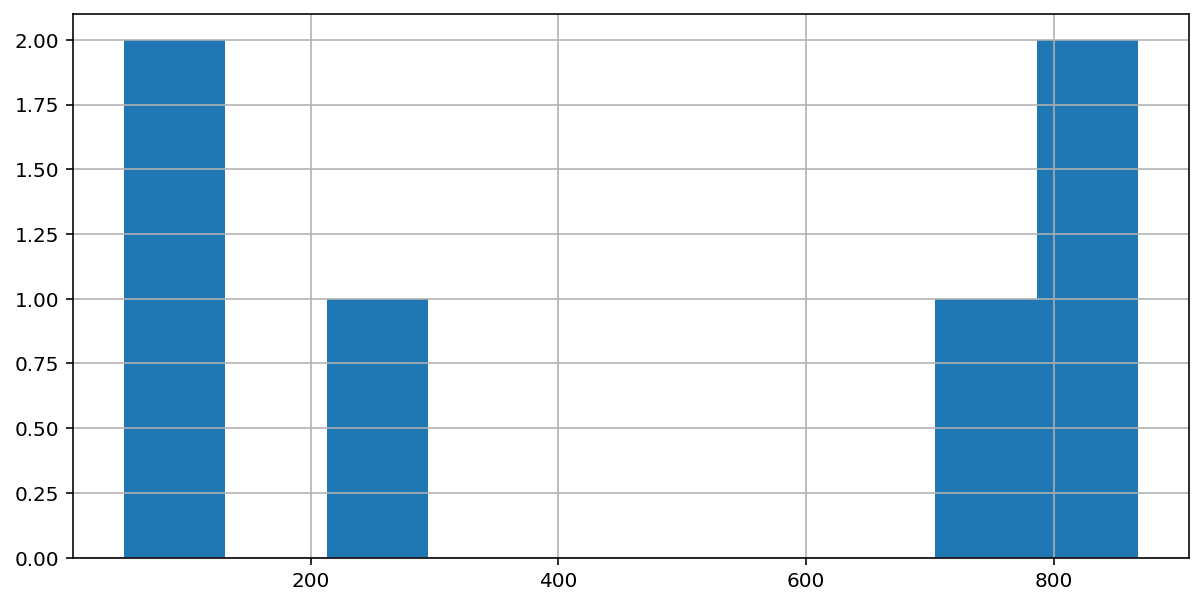

In [18]:
df_F_N =show_classification(eval_df, actual_col='EVENT_LABEL', pred_col='pred_label', actual=1, pred=0)
dp(df_F_N.head())
hist = df_F_N['score'].hist(bins=10, figsize=(10, 5))

### FP (True Positive) 분석

,score,pred_label,EVENT_LABEL,ENTITY_ID,str_app,str_device,str_os,str_channel,EVENT_TIMESTAMP,ENTITY_TYPE,EVENT_ID,LABEL_TIMESTAMP
18386,926.0,1,0,str_10239,str_36,str_1,str_13,str_373,2020-11-09 00:33:05+00:00,customer,20ce9ef3-670c-4c6b-8e83-1555c9570e49,2020-11-09T00:33:05Z
17776,967.0,1,0,str_5314,str_10,str_1,str_15,str_317,2020-11-09 13:41:24+00:00,customer,3231bc4a-efb4-4317-bcd2-c35821d61539,2020-11-09T13:41:24Z
3130,956.0,1,0,str_95766,str_29,str_1,str_19,str_210,2020-11-09 07:07:50+00:00,customer,232d8bbd-d57b-4d77-a0cf-04872d52e18d,2020-11-09T07:07:50Z
17867,940.0,1,0,str_73011,str_56,str_1,str_15,str_406,2020-11-09 10:01:00+00:00,customer,fe38f009-7eca-4b3d-9f64-11f0d7ec4e7e,2020-11-09T10:01:00Z
3012,934.0,1,0,str_100275,str_5,str_1,str_18,str_377,2020-11-09 06:37:01+00:00,customer,ec3dddcf-6211-452c-b313-0895c3d803e1,2020-11-09T06:37:01Z


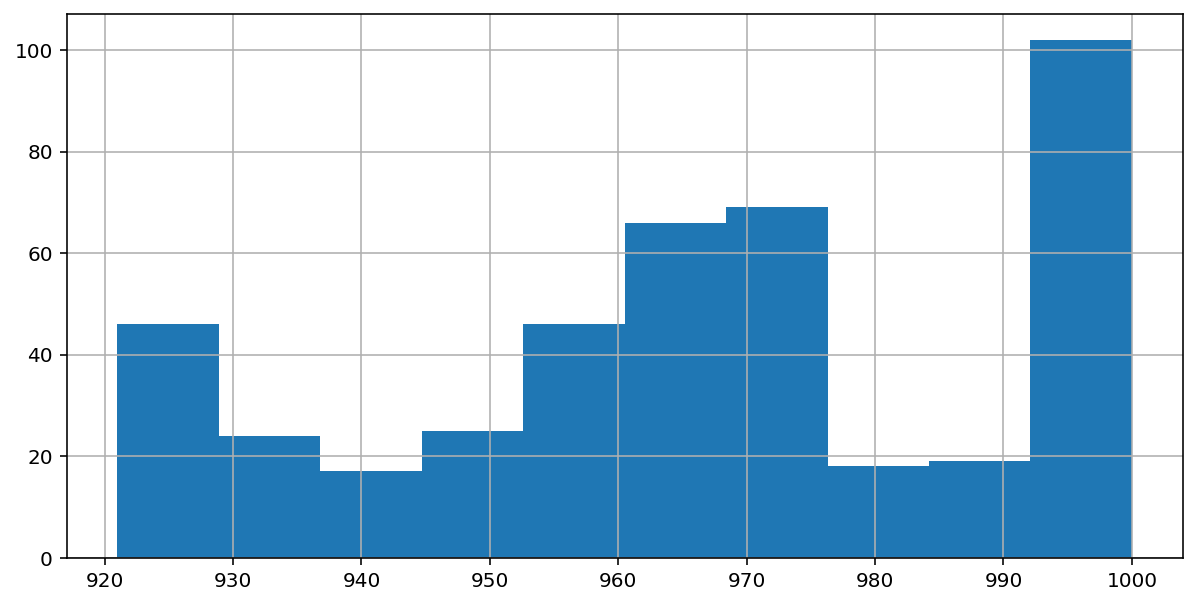

In [19]:
df_F_P =show_classification(eval_df, actual_col='EVENT_LABEL', pred_col='pred_label', actual=0, pred=1)
dp(df_F_P.head())
hist = df_F_P['score'].hist(bins=10, figsize=(10, 5))